In [43]:
%matplotlib inline

import requests
import json
from math import floor
from time import sleep
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


In [44]:
def retrieve_data(stock_code, start_date, end_date):
    """
    retrieves data from remote.
    
    Args:
    stock_code: string, stock_code
    start_data: date string in format of "YYYY-mm-dd"
    Returns: pandas.DataFrame
    """
    
    base_url = 'http://stock.liangyee.com/bus-api/stock/freeStockMarketData'
    url = base_url + '/getDailyKBar'
    user_key = 'C293FB23EC384847A4AAA3AA3DD85C9A'

    #now = datetime.now()
    #end_date = datetime.now().strftime("%Y-%m-%d")
    #start_date  = (now - timedelta(days = days_ago)).strftime("%Y-%m-%d")

    payload = {'userKey': user_key, 'symbol': stock_code, 'startDate':
            start_date, 'endDate': end_date, 'type': 0}

    response = requests.get(url, params=payload)
    if (response.status_code == requests.codes.ok):
        data = json.loads(response.content)
        result = data['result']
        
        if len(result) <= 0:
            return False 
        columns = data['columns'].split(',')[1:]
        index = []
        data_list = []
        for item in result:
            splited = item.split(',')
            index.append(splited[0])
            
            lst = [float(i) for i in splited[1:]]
            data_list.append(lst)
        return pd.DataFrame(data_list, 
                            index=index, 
                            columns=columns) 
    else:
        response.raise_for_status()
    

In [45]:
def calculate_RS(arr):
        e = np.mean(arr)
        d = [x-e for x in arr]
        x = np.cumsum(d) 
        R = np.max(x) - np.min(x)
        S = np.std(arr)
        if S != 0:
            return R/S

In [46]:
def hurst(data):
    """
    Calculates the hurst exponent for a array of float
    
    Args: 
    data: np.Array
    
    Returns: float hurst exponent
    """
    
    len_data = len(data)
    R_t = np.log(data[1:]) - np.log(data[:-1])
    n_list = range(4, floor(len_data/4)+1)
    
    RS_list = []
    for n in n_list:
        RS = np.mean([calculate_RS(R_t[i*n:(i+1)*n]) for i in range(0, floor(len_data/n))])
        RS_list.append(RS)
  
    hurst = np.polyfit(np.log(n_list), np.log(RS_list), 1)[0]
    return hurst

In [47]:
def local_hurst(data, group_len):
    """
    Calculates the local hurst exponent for a time series
    
    Args:
    data: np.Array 
    Returns: np.Array  an array of hurst exponent
    """
    if len(data) < group_len: 
        print("too few data to group.")
        return
    
    hurst_list = []
    n_list = []
  
    for i in range(0, len(data)-group_len+1):
        hurst_list.append(hurst(data[i:i+group_len]))
        n_list.append(i)
        
    return n_list, hurst_list
       

In [48]:
def anti_alias(data, step_length):
    """
    do anti alias on the given data series
    """
    result = []
    n_list = []
    
    if len(data) < step_length:
        print("too few data to anti alias")
        
    for i in range(0, len(data)-step_length):
        result.append(np.mean(data[i:i+step_length]))
        n_list.append(i+step_length)
    return n_list, result

please enter a stock code: 000001


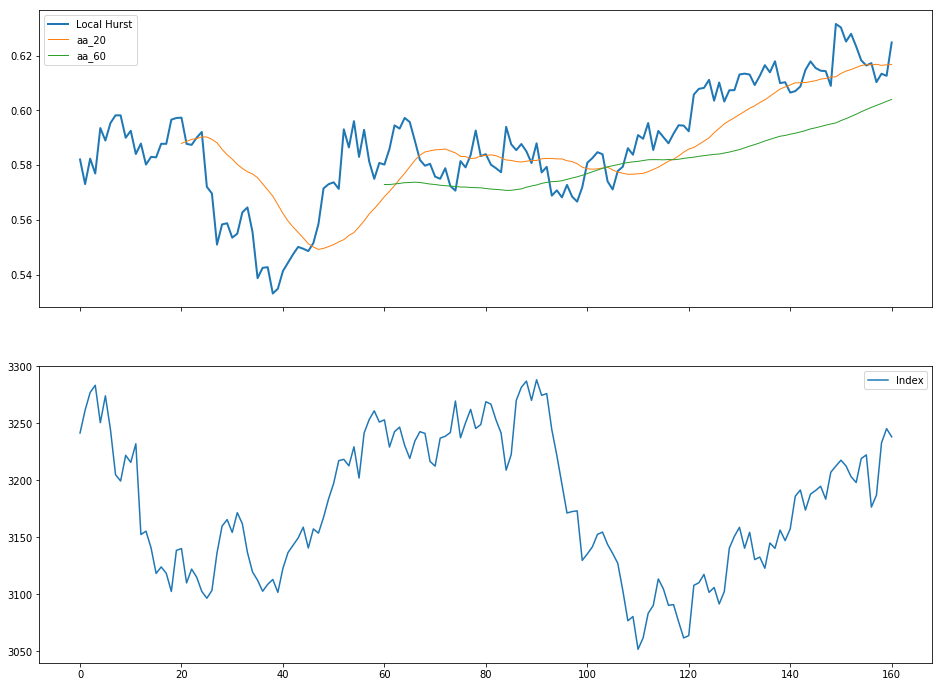

In [49]:
stock_code = input("please enter a stock code: ")

# api limits daily data to 250 per request 
data0 = retrieve_data(stock_code, "2015-01-01", "2015-12-31")
sleep(1)
data1 = retrieve_data(stock_code, "2016-01-01", "2016-12-31")
sleep(1)
data2 = retrieve_data(stock_code, "2017-01-01", "2017-07-23")


frames = [data0, data1, data2]
data = pd.concat(frames)

closing_prices = data['收盘价'].values
closing_prices = closing_prices[-500:]

# line local host
n_list, hurst_list = local_hurst(closing_prices, 240)
# 20 days anti aliased local hurst
n_list_aa20, aa20 = anti_alias(hurst_list, 20)
# 60 days anti aliased local hurst
n_list_aa60, aa60 = anti_alias(hurst_list, 60)

fg, axs = plt.subplots(2, sharex=True, figsize=(16,12))
axs[0].plot(n_list, hurst_list, linewidth=2, label="Local Hurst")
axs[0].plot(n_list_aa20, aa20, linewidth=1, label="aa_20")
axs[0].plot(n_list_aa60, aa60, linewidth=1, label="aa_60")
axs[0].legend()

# line closing prices
axs[1].plot(n_list, closing_prices[-len(n_list):], label="Index")
axs[1].legend()


